# Generación de Moléculas Similares a Inhibidores de la Telomerasa Usando WGAN-GP con R-GCN

**Author:** Brandon Villada<br>
**Description:** Desarrollar un modelo generativo basado en redes
adversariales y convolucionales sobre grafos para generar compuestos
moleculares con potencial inhibitorio de la telomerasa, inspirados en la
estructura química de Telomerase-IN-2 (CAS: 1610878-54-0).

## Introduction

La enzima telomerasa es responsable de mantener la longitud de los telómeros
en las células. Si bien su actividad es esencial en algunas células madre, se ha
identificado una reactivación anormal de la telomerasa en más del 90% de los
tipos de cáncer, permitiendo una proliferación indefinida de las células
tumorales. Además, su inhibición ha sido estudiada como una estrategia de
intervención en procesos relacionados con el envejecimiento celular.
En este proyecto se propone la generación de nuevas moléculas similares a
Telomerase-IN-2, un inhibidor que actúa sobre la telomerasa reduciendo la
expresión de dyskerina (IC50: 0.89 µM). El objetivo es aprovechar modelos
generativos profundos para explorar regiones no visitadas del espacio químico
y proponer candidatos novedosos.
### References (implementation)

La implementacion esta basada en y el trabajo de [akensert](https://github.com/akensert)
[MolGAN paper](https://arxiv.org/abs/1805.11973) and DeepChem's
[Basic MolGAN](https://deepchem.readthedocs.io/en/latest/api_reference/models.html#basicmolganmodel).


##Configuracion

Instalar RDKit
RDKit es una colección de herramientas de quimioinformática y aprendizaje automático escritas en C++ y Python. En este tutorial, RDKit se utiliza para transformar de manera conveniente y eficiente cadenas SMILES en objetos moleculares, y a partir de ellos obtener conjuntos de átomos y enlaces.

SMILES expresa la estructura de una molécula mediante una cadena ASCII. Esta representación es compacta y, en el caso de moléculas pequeñas, relativamente legible para humanos. Codificar moléculas como cadenas facilita su almacenamiento en bases de datos y su búsqueda web. RDKit utiliza algoritmos para transformar con precisión una cadena SMILES en un objeto molecular, el cual puede ser usado para calcular muchas propiedades y características moleculares.

RDKit normalmente se instala usando Conda. Sin embargo, gracias a rdkit_platform_wheels, ahora puede instalarse fácilmente con pip, como se muestra a continuación:

bash
Copiar
Editar
pip -q install rdkit-pypi
Y para permitir la visualización de objetos moleculares, también es necesario instalar Pillow:

bash
Copiar
Editar
pip -q install Pillow
Molécula de referencia: Telomerase-IN-2
Nombre: Telomerase-IN-2 (Inhibidor de Telomerasa 2)

CAS: 1610878-54-0

Actividad: Inhibidor de la telomerasa mediante disminución de la expresión de dyskerina

SMILES:
COc1cc(OC)c2c(c1)oc(-c1cc(OC)c(OC)c(OC)c1)c(OCCCCN1CCN(CC1)C(=O)c1ccncc1)c2=O

Observaciones: Esta molécula contiene varias subestructuras aromáticas y grupos funcionales como aminas terciarias y éteres, lo que la convierte en un excelente punto de partida para generar variantes estructurales.

##Dataset y Preparación
Inicialmente se consideró el uso del dataset QM9, ampliamente utilizado para tareas de predicción de propiedades moleculares. Sin embargo, se identificó una limitación clave: las moléculas contenidas en QM9 tienen pesos moleculares mucho menores (< 200 Da) y no representan adecuadamente la complejidad de fármacos reales como Telomerase-IN-2.

Por esta razón, se decidió cambiar al dataset "250k_rndm_zinc_drugs_clean_3.csv" de ZINC, el cual ofrece moléculas más grandes y realistas. Se filtraron 175,396 moléculas con pesos moleculares entre 300 y 600 Da para representar estructuras comparables a Telomerase-IN-2 (peso molecular ≈ 480 Da), resultando en 122,034 moléculas útiles.

Las moléculas se convirtieron de SMILES a grafos utilizando RDKit, generando:

Tensores de adyacencia (tipos de enlace)

Tensores de características atómicas (one-hot encoding)

Modificaciones al Código
Se amplió el diccionario de átomos para incluir elementos como C, N, O, F.

Se incrementó NUM_ATOMS de 9 (valor usado en QM9) a 80, para permitir representar estructuras más grandes.

Se ajustaron las dimensiones ATOM_DIM y BOND_DIM para reflejar el nuevo espacio de tipos de átomos y enlaces.

Se incorporó un manejo robusto de errores en la conversión SMILES → grafo para evitar descartes silenciosos.



### Import packages

In [4]:
!pip -q install rdkit-pypi
!pip -q install Pillow
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import tensorflow as tf

RDLogger.DisableLog("rdApp.*")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

El dataset "250k_rndm_zinc_drugs_clean_3.csv" de ZINC, el cual ofrece moléculas más grandes y realistas. Se filtraron 175,396 moléculas con pesos moleculares entre 300 y 600 Da para representar estructuras comparables a Telomerase-IN-2 (peso molecular ≈ 480 Da), resultando en 122,034 moléculas útiles.

Este se descargo desde la plataforma de kaggle.

Columnas disponibles: Index(['smiles', 'logP', 'qed', 'SAS'], dtype='object')
Total moléculas: 173575
Moléculas entre 300 y 600 Da: 122034
SMILES: COc1cc(OC)c2c(c1)oc(-c1cc(OC)c(OC)c(OC)c1)c(OCCCCN1CCN(CC1)C(=O)c1ccncc1)c2=O
Num heavy atoms: 46


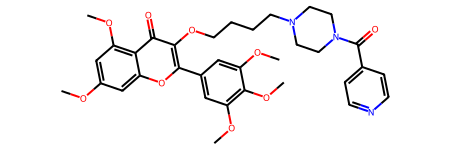

In [6]:
df = pd.read_csv("250k_rndm_zinc_drugs_clean_3.csv")
print("Columnas disponibles:", df.columns)
print("Total moléculas:", len(df))

# Paso 2: obtener la columna de SMILES
smiles_list = df["smiles"].tolist()  # asegúrate que la columna se llame 'smiles'

# Paso 3: filtrar por peso molecular
def filter_by_mw(smiles_list, min_mw=300, max_mw=600):
    filtered = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            mw = Descriptors.MolWt(mol)
            if min_mw <= mw <= max_mw:
                filtered.append(smi)
    return filtered

filtered_smiles = filter_by_mw(smiles_list, 300, 600)
print("Moléculas entre 300 y 600 Da:", len(filtered_smiles))

# Let's look at a molecule of the dataset
smiles = "COc1cc(OC)c2c(c1)oc(-c1cc(OC)c(OC)c(OC)c1)c(OCCCCN1CCN(CC1)C(=O)c1ccncc1)c2=O"
print("SMILES:", smiles)
molecule = Chem.MolFromSmiles(smiles)
print("Num heavy atoms:", molecule.GetNumHeavyAtoms())
molecule

### Definir funciones auxiliares
Estas funciones auxiliares permitirán convertir cadenas SMILES a grafos moleculares y viceversa, de grafos a objetos moleculares.

Representación de un grafo molecular
Las moléculas pueden representarse naturalmente como grafos no dirigidos G = (V, E), donde:

V es el conjunto de vértices (átomos),

E es el conjunto de aristas (enlaces).

En esta implementación, cada grafo (molécula) se representará mediante:

Un tensor de adyacencia A, que codifica la existencia o no de pares de átomos conectados, junto con el tipo de enlace entre ellos, codificado en formato one-hot en una dimensión adicional.

Un tensor de características H, que codifica para cada átomo su tipo atómico mediante one-hot encoding.

Nota: Los átomos de hidrógeno se excluyen tanto de A como de H, ya que pueden inferirse automáticamente mediante RDKit. Esto simplifica el modelado.

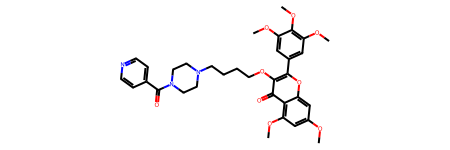

In [7]:
atom_mapping = {
    "C": 0,
    0: "C",
    "N": 1,
    1: "N",
    "O": 2,
    2: "O",
    "F": 3,
    3: "F",
}

bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}

NUM_ATOMS = 80
ATOM_DIM = 4 + 1  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 64  # Size of the latent space


def smiles_to_graph(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None or molecule.GetNumAtoms() > NUM_ATOMS:
        return None

    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), dtype="float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), dtype="float32")

    try:
        for atom in molecule.GetAtoms():
            i = atom.GetIdx()
            atom_type = atom_mapping.get(atom.GetSymbol(), ATOM_DIM - 1)
            features[i] = np.eye(ATOM_DIM)[atom_type]

            for neighbor in atom.GetNeighbors():
                j = neighbor.GetIdx()
                bond = molecule.GetBondBetweenAtoms(i, j)
                bond_type_idx = bond_mapping.get(bond.GetBondType().name, BOND_DIM - 1)
                adjacency[bond_type_idx, [i, j], [j, i]] = 1

        # Donde no hay enlace, marcar como "no-bond"
        adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1
        # Donde no hay átomo, marcar como "non-atom"
        features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    except Exception as e:
        print(f"❌ SMILES inválido: {smiles} — {e}")
        return None

    return adjacency, features

# Reconstruye una molécula RDKit desde los tensores
def graph_to_molecule(graph):
    adjacency, features = graph
    molecule = Chem.RWMol()

    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

# Test helper functions
graph_to_molecule(smiles_to_graph(smiles))

##Arquitectura del Modelo
Se desarrolló una arquitectura basada en WGAN-GP (Wasserstein GAN con penalización de gradiente), adecuada para tareas de generación de grafos moleculares debido a su estabilidad durante el entrenamiento.

Componentes del modelo:
Generador: recibe como entrada un vector latente de dimensión 64 y genera como salida grafos moleculares que representan posibles estructuras químicas.

Discriminador: evalúa si un grafo dado proviene del conjunto real (moléculas verdaderas del dataset) o ha sido generado por el modelo.

Mejoras y estabilización:
Se utilizó WGAN con penalización de gradiente (WGAN-GP), lo cual introduce robustez durante el entrenamiento mediante los siguientes mecanismos:

gp_weight = 1.0: peso asignado al término de penalización de gradiente.

Clipping de logits del discriminador: para evitar salidas extremas que dificulten la retropropagación.

Control de la norma del gradiente con clip_by_norm: evita explosión de gradientes al limitar su magnitud.

Entrenamiento:
Dispositivo: GPU T4

Épocas: 100

Tamaño de batch: 16

Este enfoque permitió una generación más estable y precisa de moléculas sintéticas, manteniendo propiedades estructurales realistas.

In [8]:
adjacency_tensor, feature_tensor = [], []
data = filtered_smiles
for smiles in data[::10]:
    result = smiles_to_graph(smiles)
    if result:
        adjacency, features = result
        adjacency_tensor.append(adjacency)
        feature_tensor.append(features)

# 🔧 Convertir primero a np.array para asegurar forma correcta
adjacency_tensor = tf.convert_to_tensor(np.array(adjacency_tensor), dtype=tf.float32)
feature_tensor = tf.convert_to_tensor(np.array(feature_tensor), dtype=tf.float32)

print("adjacency_tensor.shape =", adjacency_tensor.shape)
print("feature_tensor.shape =", feature_tensor.shape)

adjacency_tensor.shape = (12204, 5, 80, 80)
feature_tensor.shape = (12204, 80, 5)


In [9]:
def GraphGenerator(
    dense_units,
    dropout_rate,
    latent_dim,
    adjacency_shape,
    feature_shape,
):
    z = keras.layers.Input(shape=(latent_dim,), name="latent_input")

    x = z
    for i, units in enumerate(dense_units):
        x = keras.layers.Dense(units, activation="tanh", name=f"dense_{i}")(x)
        x = keras.layers.Dropout(dropout_rate, name=f"dropout_{i}")(x)

    adj_total_dim = int(np.prod(adjacency_shape))
    feat_total_dim = int(np.prod(feature_shape))

    # Adjacency tensor
    x_adjacency = keras.layers.Dense(adj_total_dim, name="adjacency_dense")(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape, name="adjacency_reshape")(x_adjacency)
    x_adjacency_transpose = keras.layers.Lambda(
        lambda t: tf.transpose(t, perm=(0, 1, 3, 2)), name="adjacency_transpose"
    )(x_adjacency)
    x_adjacency = keras.layers.Average(name="adjacency_symmetrize")(
        [x_adjacency, x_adjacency_transpose]
    )
    x_adjacency = keras.layers.Softmax(axis=1, name="adjacency_softmax")(x_adjacency)

    # Feature tensor
    x_features = keras.layers.Dense(feat_total_dim, name="feature_dense")(x)
    x_features = keras.layers.Reshape(feature_shape, name="feature_reshape")(x_features)
    x_features = keras.layers.Softmax(axis=2, name="feature_softmax")(x_features)

    return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name="GraphGenerator")


generator = GraphGenerator(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
generator.summary()

Model: "GraphGenerator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latent_input        │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_0 (Dense)     │ (None, 128)       │      8,320 │ latent_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_0 (Dropout) │ (None, 128)       │          0 │ dense_0[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     33,024 │ dropout_0[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    131,584 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjacency_dense     │ (None, 32000)     │ 16,416,000 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjacency_reshape   │ (None, 5, 80, 80) │          0 │ adjacency_dense[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjacency_transpose │ (None, 5, 80, 80) │          0 │ adjacency_reshap… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_dense       │ (None, 400)       │    205,200 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjacency_symmetri… │ (None, 5, 80, 80) │          0 │ adjacency_reshap… │
│ (Average)           │                   │            │ adjacency_transp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_reshape     │ (None, 80, 5)     │          0 │ feature_dense[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjacency_softmax   │ (None, 5, 80, 80) │          0 │ adjacency_symmet… │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_softmax     │ (None, 80, 5)     │          0 │ feature_reshape[… │
│ (Softmax)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,794,128 (64.06 MB)

 Trainable params: 16,794,128 (64.06 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)


def GraphDiscriminator(
    gconv_units, dense_units, dropout_rate, adjacency_shape, feature_shape
):

    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )

    # Reduce 2-D representation of molecule to 1-D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # For each molecule, output a single scalar value expressing the
    # "realness" of the inputted molecule
    x_out = keras.layers.Dense(1, dtype="float32")(x)

    return keras.Model(inputs=[adjacency, features], outputs=x_out)


discriminator = GraphDiscriminator(
    gconv_units=[128, 128, 128, 128],
    dense_units=[512, 512],
    dropout_rate=0.2,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
discriminator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 80, 80) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 80, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 80, 128)   │      3,200 │ input_layer[0][0… │
│ (RelationalGraphCo… │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 80, 128)   │     81,920 │ input_layer[0][0… │
│ (RelationalGraphCo… │                   │            │ relational_graph… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 80, 128)   │     81,920 │ input_layer[0][0… │
│ (RelationalGraphCo… │                   │            │ relational_graph… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 80, 128)   │     81,920 │ input_layer[0][0… │
│ (RelationalGraphCo… │                   │            │ relational_graph… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ relational_graph… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │     66,048 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    262,656 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        513 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 578,177 (2.21 MB)

 Trainable params: 578,177 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

### WGAN-GP

In [11]:
class GraphWGAN(keras.Model):
    def __init__(
        self,
        generator,
        discriminator,
        discriminator_steps=1,
        generator_steps=1,
        gp_weight=1.0,  # 🔧 Reducción para estabilidad
        **kwargs
    ):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.discriminator_steps = discriminator_steps
        self.generator_steps = generator_steps
        self.gp_weight = gp_weight
        self.latent_dim = self.generator.input_shape[-1]

    def compile(self, optimizer_generator, optimizer_discriminator, **kwargs):
        super().compile(**kwargs)
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.metric_generator = keras.metrics.Mean(name="loss_gen")
        self.metric_discriminator = keras.metrics.Mean(name="loss_dis")

    def train_step(self, inputs):
        if isinstance(inputs[0], tuple):
            inputs = inputs[0]

        adjacency_real, features_real = inputs
        batch_size = tf.shape(adjacency_real)[0]

        # --- Train Discriminator ---
        for _ in range(self.discriminator_steps):
            z = tf.random.normal((batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                adjacency_fake, features_fake = self.generator(z, training=True)
                loss_d = self._loss_discriminator(
                    (adjacency_real, features_real),
                    (adjacency_fake, features_fake),
                    batch_size
                )

            grads = tape.gradient(loss_d, self.discriminator.trainable_weights)
            grads = [tf.clip_by_norm(g, 10.0) for g in grads]
            self.optimizer_discriminator.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            self.metric_discriminator.update_state(loss_d)

        # --- Train Generator ---
        for _ in range(self.generator_steps):
            z = tf.random.normal((batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                adjacency_fake, features_fake = self.generator(z, training=True)
                logits_fake = self.discriminator([adjacency_fake, features_fake], training=True)
                logits_fake = tf.clip_by_value(logits_fake, -1e5, 1e5)  # 🔧 estabilidad
                loss_g = -tf.reduce_mean(logits_fake)

            grads = tape.gradient(loss_g, self.generator.trainable_weights)
            self.optimizer_generator.apply_gradients(zip(grads, self.generator.trainable_weights))
            self.metric_generator.update_state(loss_g)

        return {m.name: m.result() for m in self.metrics}

    def _loss_discriminator(self, real, fake, batch_size):
        adjacency_real, features_real = real
        adjacency_fake, features_fake = fake

        logits_real = self.discriminator([adjacency_real, features_real], training=True)
        logits_fake = self.discriminator([adjacency_fake, features_fake], training=True)

        logits_real = tf.clip_by_value(logits_real, -1e5, 1e5)  # 🔧 estabilidad
        logits_fake = tf.clip_by_value(logits_fake, -1e5, 1e5)

        wasserstein_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real)
        gp = self._gradient_penalty(real, fake, batch_size)
        return wasserstein_loss + self.gp_weight * gp

    def _gradient_penalty(self, real, fake, batch_size):
        adjacency_real, features_real = real
        adjacency_fake, features_fake = fake

        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        adjacency_interp = alpha * adjacency_real + (1 - alpha) * adjacency_fake

        alpha_feat = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        features_interp = alpha_feat * features_real + (1 - alpha_feat) * features_fake

        with tf.GradientTape() as tape:
            tape.watch([adjacency_interp, features_interp])
            logits = self.discriminator([adjacency_interp, features_interp], training=True)

        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        grad_adj = tf.reshape(grads[0], [batch_size, -1])
        grad_feat = tf.reshape(grads[1], [batch_size, -1])

        grad_norm_adj = tf.sqrt(tf.reduce_sum(tf.square(grad_adj), axis=1) + 1e-12)
        grad_norm_feat = tf.sqrt(tf.reduce_sum(tf.square(grad_feat), axis=1) + 1e-12)

        gp = tf.square(grad_norm_adj - 1.0) + tf.square(grad_norm_feat - 1.0)
        return tf.reduce_mean(gp)

## Resultados del Entrenamiento
El generador presentó una pérdida (loss_gen) oscilando entre -3 y +2.5, lo que indica cierto progreso en el aprendizaje.

El discriminador se mantuvo relativamente estable, aunque con algunos picos ocasionales por encima de 100, lo cual es esperado en modelos GAN.

Tras 20 épocas:
Se generó únicamente 1 molécula válida.

No se observó ninguna correlación evidente con la estructura de Telomerase-IN-2.

Muchas salidas fueron None debido a fallos en la sanitización o problemas de conectividad en el grafo molecular.

Tras 100 épocas:
Solo se generaron 2 moléculas válidas.

Tampoco se observó correlación con Telomerase-IN-2.

Persistieron múltiples salidas inválidas (None) por errores en la representación estructural de los grafos.

##Análisis Crítico
A pesar de que el entrenamiento fue estable desde el punto de vista numérico, el modelo no logró generalizar adecuadamente hacia estructuras moleculares significativas. Se identificaron los siguientes factores limitantes:

Dataset genérico: aunque se filtró un subconjunto de moléculas del dataset ZINC, muchas siguen siendo estructuralmente diferentes del objetivo (Telomerase-IN-2).

Falta de guía: el modelo no cuenta con ninguna función de pérdida que incentive similitud o afinidad hacia Telomerase-IN-2.

Ausencia de reconstrucción: al no utilizar un enfoque basado en VAE (Autoencoder Variacional) o similar, el modelo no se ve obligado a preservar información estructural relevante.

In [12]:
with tf.device("/GPU:0"):
    wgan = GraphWGAN(generator, discriminator, discriminator_steps=5)

    wgan.compile(
        optimizer_generator=keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9),
        optimizer_discriminator=keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9),
    )

    # ✅ Aquí usamos una TUPLA
    wgan.fit(
        (adjacency_tensor, feature_tensor),
        epochs=100,
        batch_size=16
    )

Epoch 1/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 183s 120ms/step - loss: 0.0000e+00 - loss_dis: 352684.3438 - loss_gen: 159.8510
Epoch 2/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 88s 53ms/step - loss: 0.0000e+00 - loss_dis: 8.0539 - loss_gen: -0.5769
Epoch 3/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - loss: 0.0000e+00 - loss_dis: -0.0781 - loss_gen: -0.7668
Epoch 4/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - loss: 0.0000e+00 - loss_dis: 0.1583 - loss_gen: -0.9589
Epoch 5/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - loss: 0.0000e+00 - loss_dis: 0.1734 - loss_gen: -0.9592
Epoch 6/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - loss: 0.0000e+00 - loss_dis: 0.1304 - loss_gen: -1.2680
Epoch 7/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - loss: 0.0000e+00 - loss_dis: 0.1436 - loss_gen: -0.8208
Epoch 8/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - loss: 0.0000e+00 - loss_dis: 0.1720 - loss_gen: -0.7666
Epoch 9/100
763/763 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - loss: 0.0000e+00 - loss_dis: 1

## Sample novel molecules with the generator

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, <rdkit.Chem.rdchem.RWMol object at 0x78a01547a7f0>, None, None, None, None, None, None, None, None, None, None, None, None]


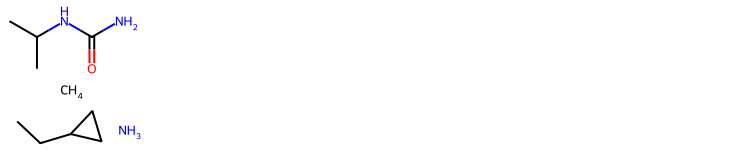

In [26]:
def sample(generator, batch_size):
    z = tf.random.normal((batch_size, LATENT_DIM))
    graph = generator.predict(z)

    adjacency_raw = tf.argmax(graph[0], axis=1)
    features_raw = tf.argmax(graph[1], axis=2)

    # One-hot encodings
    adjacency = tf.one_hot(adjacency_raw, depth=BOND_DIM, axis=1)
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
    features = tf.one_hot(features_raw, depth=ATOM_DIM, axis=2)

    return [
        graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
        for i in range(batch_size)
    ]
molecules = sample(wgan.generator, batch_size=48)
print(molecules)
MolsToGridImage(
    [m for m in molecules if m is not None][:25], molsPerRow=5, subImgSize=(150, 150)
)

# Recomendaciones y Siguientes Pasos
A partir del análisis de resultados, se proponen las siguientes estrategias para mejorar la calidad y relevancia de las moléculas generadas:

##1. Reentrenamiento Dirigido
Buscar análogos estructurales de Telomerase-IN-2 en bases de datos como ZINC o ChEMBL.

Aplicar filtros por similitud de Tanimoto > 0.7 para asegurar cercanía estructural.

Seleccionar moléculas con motivos estructurales comunes (por ejemplo, grupos funcionales, anillos aromáticos compartidos).

##2. Modelos Alternativos
Implementar un GraphVAE o Junction Tree VAE (JTVAE), que permiten:

Reconstrucción estructural.

Preservación de conectividad química válida.

Incluir un módulo de aprendizaje por refuerzo que optimice propiedades deseadas como:

QED (Drug-likeness)

Docking score

Reglas de Lipinski.

##3. Evaluación Automática
Incorporar métricas periódicas de calidad para cada bloque de épocas:

Validez: porcentaje de moléculas químicamente válidas.

Unicidad: proporción de moléculas no duplicadas.

Similitud estructural: distancia respecto a Telomerase-IN-2 (e.g., Tanimoto).

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-wgan%20graphs-black.svg)](https://huggingface.co/keras-io/wgan-molecular-graphs) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-wgan%20graphs-black.svg)](https://huggingface.co/spaces/keras-io/Generating-molecular-graphs-by-WGAN-GP) |